# Interpreting Alphalens' tear sheets

In the [previous lesson](link_to_prev), you learned how to query and process data so that we can analyze it with Alphalens tear sheets. In this lesson, you will experience a few iterations of the alpha discovery phase of the [quant workflow](link) by analyzing those tear sheets.

In this lesson, we will:

1. Analyze how well an alpha factor predicts future price movements with `create_information_tear_sheet()`.
2. Try to improve our original alpha factor by combining it with another alpha factor.
3. Preview how profitable our alpha factor might be with `create_returns_tear_sheet()`.

### 1. Our starting alpha factor:

The following code expresses an alpha factor based on a company's net income and market cap, and then creates an information tear sheet for that alpha factor. We will start analyzing the alpha factor by looking at it's information coefficient (IC). The IC is a number ranging from -1, to 1, which quantifies the predictiveness of an alpha factor. Any number above 0 is considered somewhat predictive.

The first number you should look at is the IC mean, which is an alpha factor's average IC over a given time period. You want your factor's IC Mean to be as high as possible. Generally speaking, a factor is worth investigating if it has an IC mean over 0. If it has an IC mean close to .1 (or higher) over a large trading universe, that factor is probably really good.

**Run the cell below to create an information tear sheet for our alpha factor. Notice how the IC Mean figures (the first numbers on the first chart) are all positive. That is a good sign!**

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.006,0.006,0.006
IC Std.,0.108,0.107,0.098
Risk-Adjusted IC,0.057,0.060,0.058
t-stat(IC),1.276,1.355,1.312
p-value(IC),0.203,0.176,0.190
IC Skew,0.023,0.165,0.153
IC Kurtosis,-0.177,-0.224,-0.562


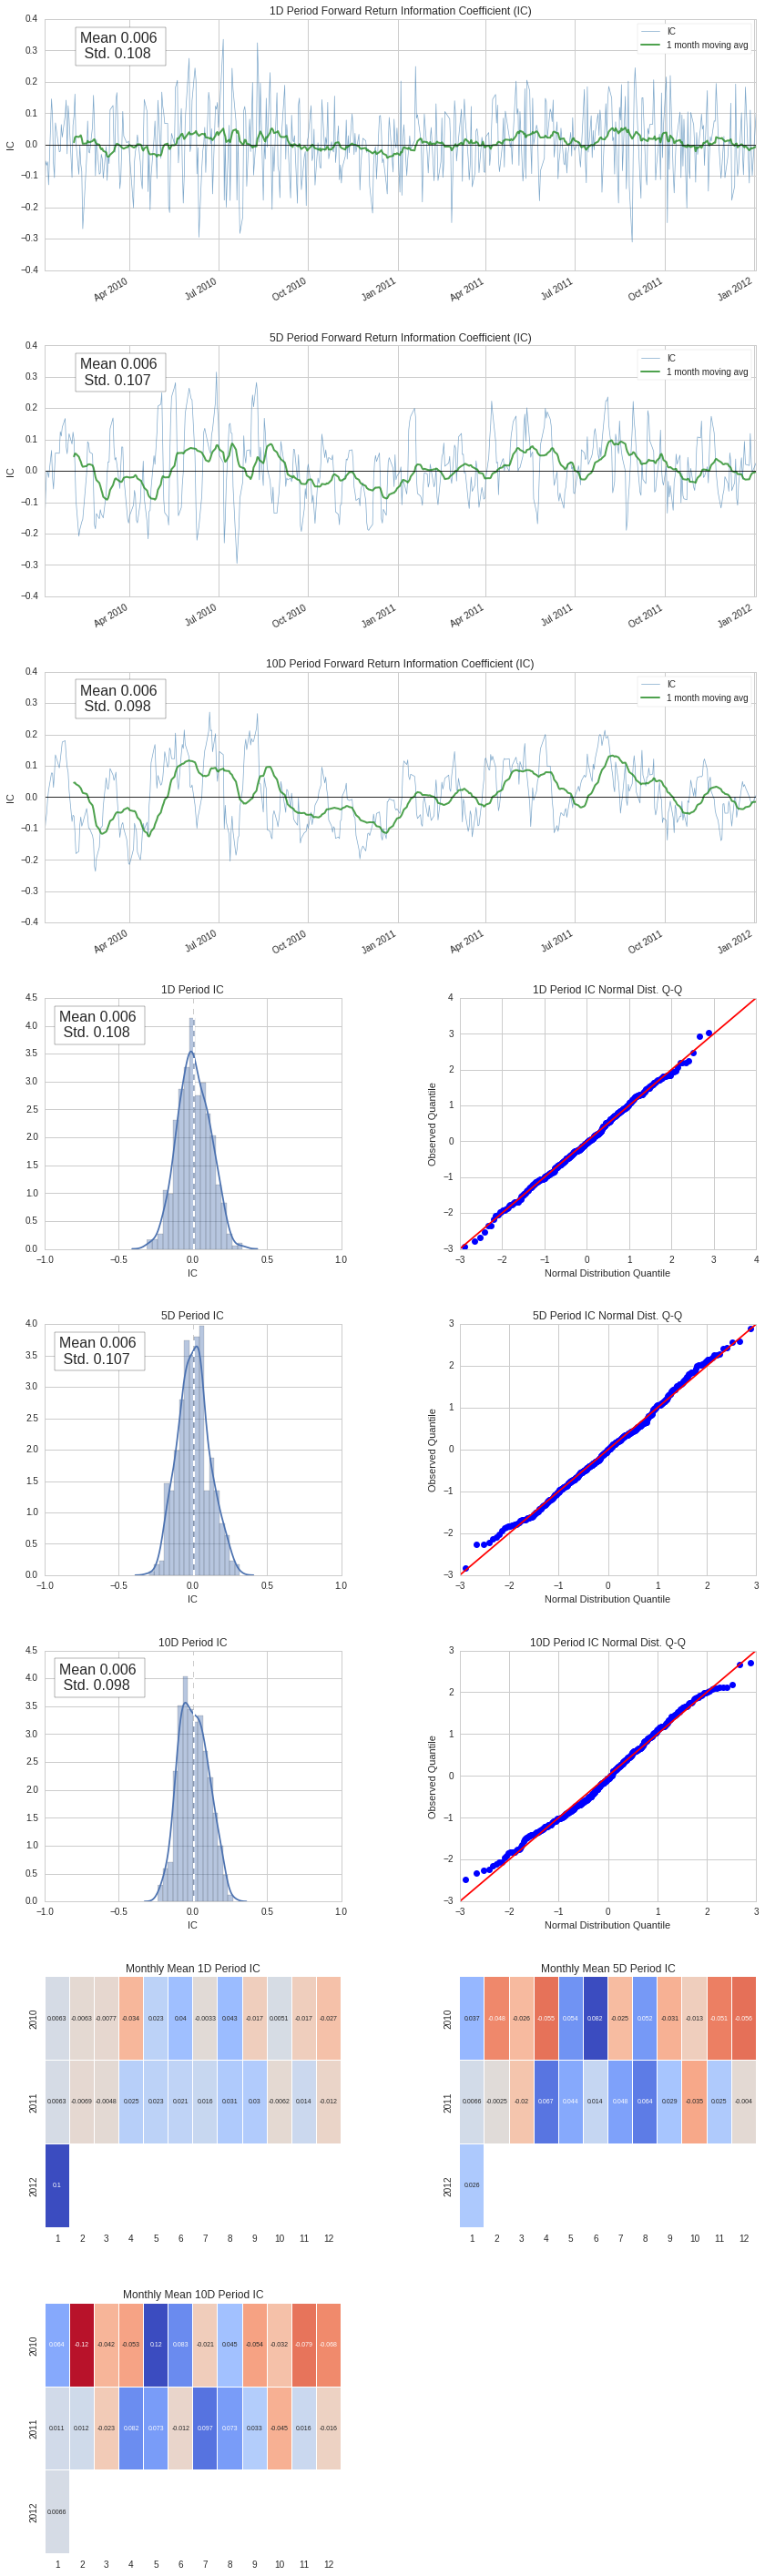

In [4]:
from quantopian.pipeline.data import factset # Data from FactSet is *** n o w _ a v a i l a b l e ***

from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import CustomFactor, SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns


def make_pipeline():

    net_income_moving_average = SimpleMovingAverage( # 1 year moving average of year over year net income
        inputs=[factset.Fundamentals.net_inc_af], 
        window_length=252
    )
    
    market_cap_moving_average = SimpleMovingAverage( # 1 year moving average of market cap
        inputs=[factset.Fundamentals.mkt_val], 
        window_length=252
    )
    
    average_market_cap_per_net_income = (market_cap_moving_average / net_income_moving_average)
    
    net_income = factset.Fundamentals.net_inc_qf.latest # the last quarter's net income
    
    projected_market_cap = average_market_cap_per_net_income * net_income
    
    return Pipeline(
        columns = {'projected_market_cap': projected_market_cap},
        screen = QTradableStocksUS() & projected_market_cap.notnull()
    )


factor_data = run_pipeline(make_pipeline(), '2010-1-1', '2012-1-1')
pricing_data = get_pricing(factor_data.index.levels[1], '2010-1-1', '2012-2-1', fields='open_price')
merged_data = get_clean_factor_and_forward_returns(factor_data, pricing_data)

create_information_tear_sheet(merged_data)

### 2. Add another alpha factor

**Alphalens is useful for identifying alpha factors that aren't predictive early in the quant workflow. This allows you to avoid wasting time running a full backtest on a factor that could have been discarded earlier in the process.**

Run the following cell to express another alpha factor called `price_to_book`, combine it with projected_market_cap using zscores and winsorizing, then creates another information tearsheet based on our new (and hopefully improved) alpha factor. 

Notice how the IC figures are lower than they were in the first chart. That means the factor we added is making our predictions worse!

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Information Analysis


,1D,5D,10D
IC Mean,0.002,0.004,0.005
IC Std.,0.094,0.100,0.096
Risk-Adjusted IC,0.026,0.036,0.049
t-stat(IC),0.495,0.701,0.944
p-value(IC),0.621,0.484,0.346
IC Skew,0.084,0.054,0.043
IC Kurtosis,-0.265,-0.417,-0.680


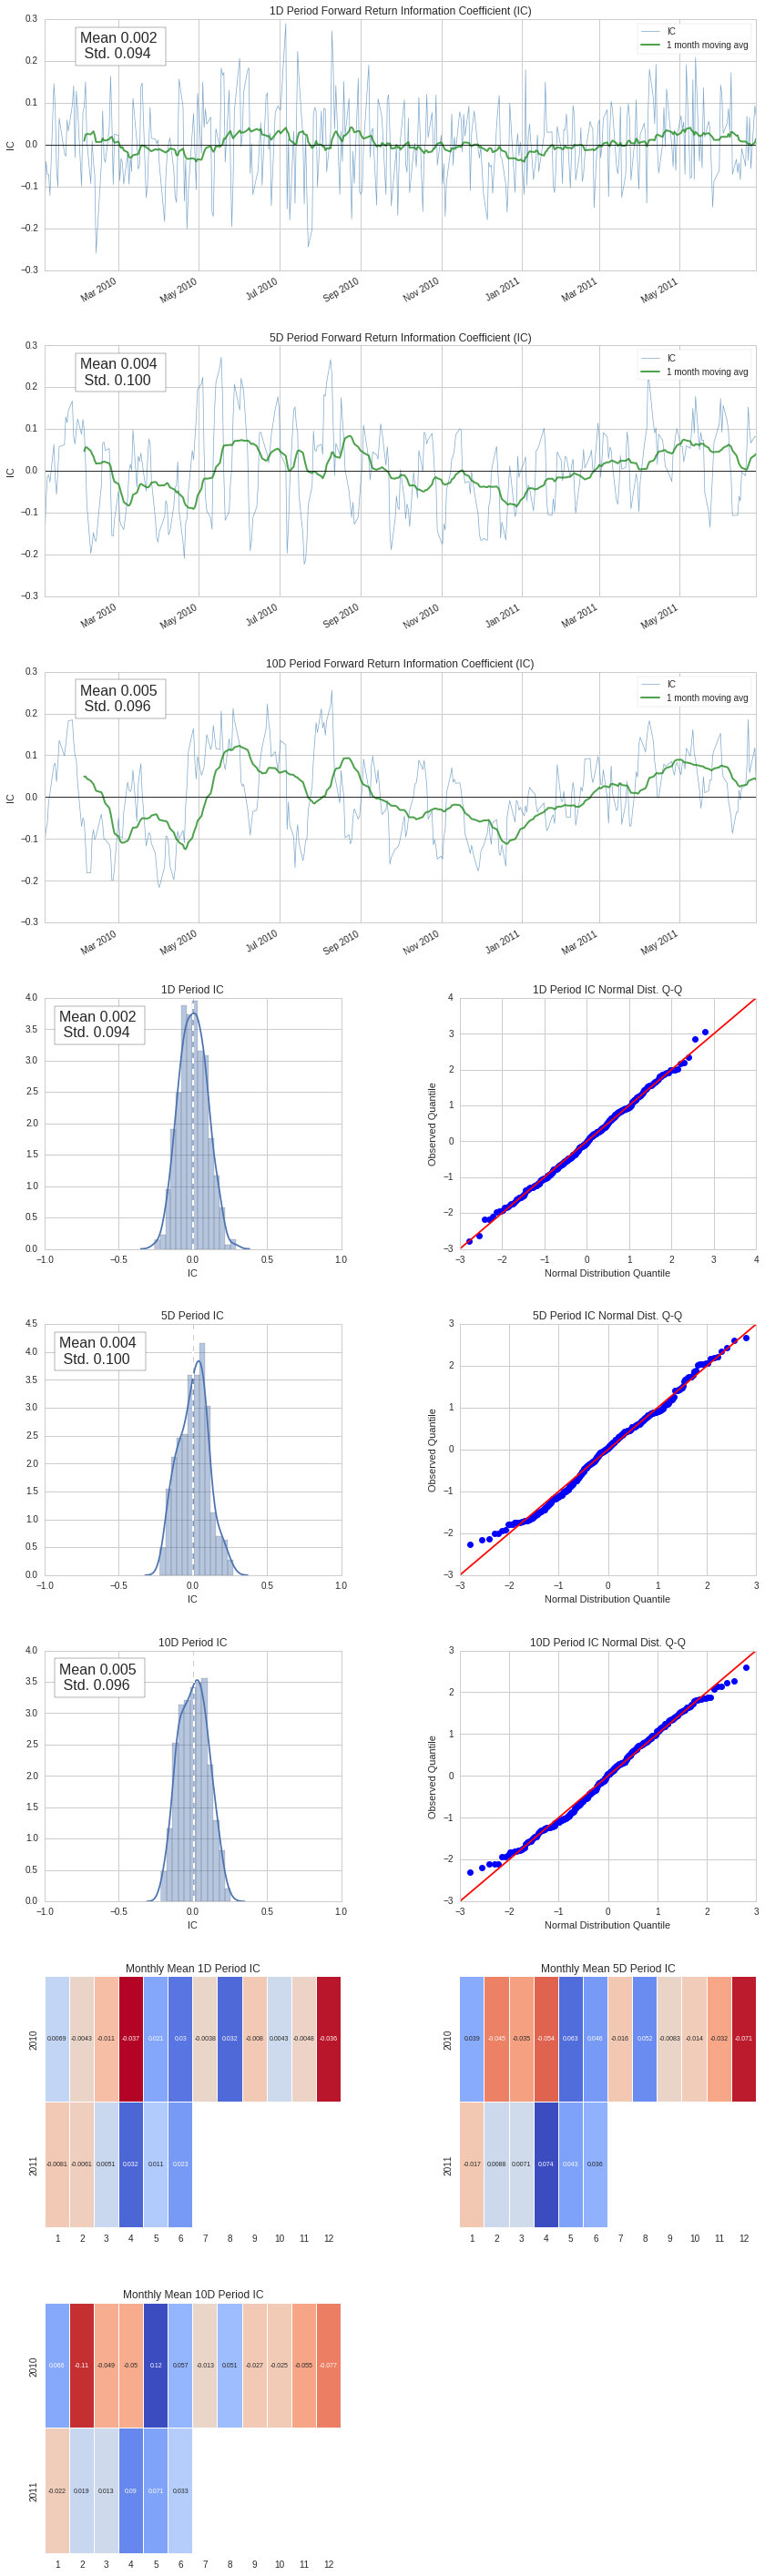

In [5]:
def make_pipeline():

    net_income_moving_average = SimpleMovingAverage( # 1 year moving average of year over year net income
        inputs=[factset.Fundamentals.net_inc_af], 
        window_length=252
    )
    
    market_cap_moving_average = SimpleMovingAverage( # 1 year moving average of market cap
        inputs=[factset.Fundamentals.mkt_val], 
        window_length=252
    )
    
    average_market_cap_per_net_income = (market_cap_moving_average / net_income_moving_average)
    
    net_income = factset.Fundamentals.net_inc_qf.latest # the last quarter's net income
    
    projected_market_cap = average_market_cap_per_net_income * net_income
    
    price_to_book = factset.Fundamentals.pbk_qf.latest
    
    factor_to_analyze = projected_market_cap.zscore() + price_to_book.zscore()
    
    return Pipeline(
        columns = {'factor_to_analyze': factor_to_analyze},
        screen = QTradableStocksUS() & factor_to_analyze.notnull()
    )



factor_data = run_pipeline(make_pipeline(), '2010-1-1', '2012-1-1')
pricing_data = get_pricing(factor_data.index.levels[1], '2010-1-1', '2012-2-1', fields='open_price')
new_merged_data = get_clean_factor_and_forward_returns(factor_data, pricing_data)

create_information_tear_sheet(new_merged_data)

### See if our alpha factor might be profitable

We found that the first iteration of our alpha factor had more predictive value than the second one. Let's see if the original alpha factor might make any money.

`create_returns_tear_sheet()` splits your universe into [quantiles](link_to_def), then shows the returns generated by each quantile over different time periods. Quantile 1 is the 20% of assets with the lowest alpha factor values, and quantile 5 is the highest 20%.

This function creates six types of charts, but the two most important ones are:

- **Mean period wise returns by factor quantile:** This chart shows the average return for each quantile in your universe, per time period. You want to the quantiles on the left to have negative values, and the ones on the right to have positive values.
- **Cumulative return by quantile:** This chart shows you how each quantile performed over time. You want to see quantile 1 consistently performing the worst, quantile 5 consistently performing the best, and the other quantiles in the middle. 

**Run the following cell, and notice how quantile 5 doesn't have the highest returns. Ideally, you want quantile 1 to have the lowest returns, and quantile 5 to have the highest returns. This tear sheet is telling us we still have work to do!**

Returns Analysis


,1D,5D,10D
Ann. alpha,NaN,NaN,NaN
beta,NaN,NaN,NaN
Mean Period Wise Return Top Quantile (bps),-1.212,-1.291,-1.328
Mean Period Wise Return Bottom Quantile (bps),-0.789,-0.753,-0.840
Mean Period Wise Spread (bps),-0.608,-0.696,-0.635


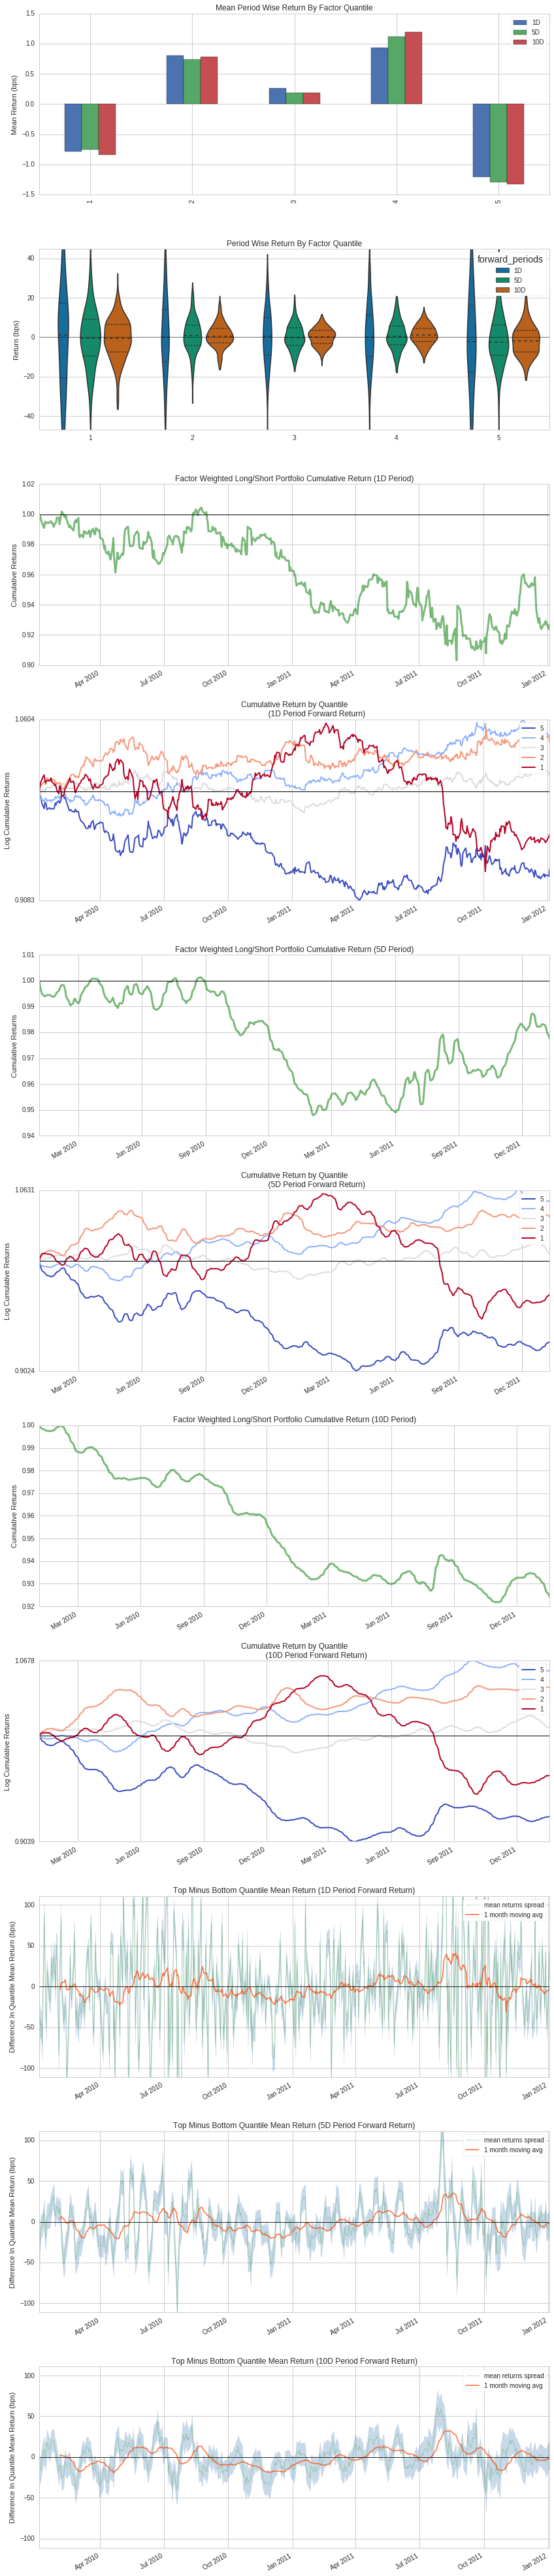

In [6]:
from alphalens.tears import create_returns_tear_sheet

create_returns_tear_sheet(merged_data)

In this lesson, you experienced a few cycles of the alpha discovery stage of the quant worfklow. Making good alpha factors isn't easy, but Alphalens allows you to iterate through them quickly to find out if you're on the right track! You can usually improve existing alpha factors in some way by getting creative with moving averages, looking for trend reversals, or any number of other stratgies.

Try looking around [Quantopian's forums](https://www.quantopian.com/posts), or reading academic papers for inspiration. This is where you get to be creative! In the next lesson, we'll discuss advanced Alphalens concepts.